In [1]:
import torch
import gpytorch
import numpy as np
import pandas as pd

from bo_functions import calc_ei_basic
from bo_functions import ExactGPModel
from bo_functions import calc_GP_outputs
from bo_functions import train_GP_model

from bo_plotters import plot_hyperparams
from bo_plotters import y_plotter_basic
from bo_plotters import stdev_plotter_basic
from bo_plotters import ei_plotter_basic

In [2]:
#Pull x data from CSV
exp_data_doc = "exp_data.csv"
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
# print(x)

In [3]:
#Pull training data from CSV
train_data_doc = "train_2_in_data.csv"
train_data = np.array(pd.read_csv(train_data_doc, header=0,sep=","))
train_T = torch.tensor(train_data[:,1:3])
train_sse = torch.tensor(train_data[:,3])

In [4]:
# from bo_functions import create_sse_data
# Theta1 =  np.linspace(-2,2,10) #1x10
# Theta2 =  np.linspace(-2,2,10) #1x10
# theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays
# train_T = torch.tensor(theta_mesh.T.reshape(-1, 2)) #25 x 2
# train_sse = create_sse_data(train_T, Xexp, Yexp)
# Note - If using for comparison make sure to change test space accordingly

In [5]:
# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# We will use the simplest form of GP model, exact inference
#Defines our model in terms of the class parameters in bo_functions
model = ExactGPModel(train_T, train_sse, likelihood)

In [6]:
#Training the GP Model
iterations = 7000
train_GP = train_GP_model(model, likelihood, train_T, train_sse, iterations, verbose = False)
noise_list = train_GP[0]
lengthscale_list = train_GP[1]
outputscale_list = train_GP[2]

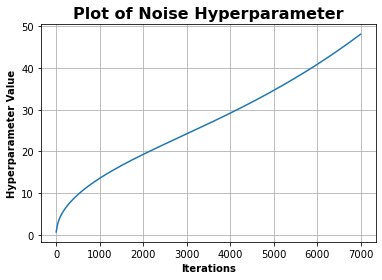

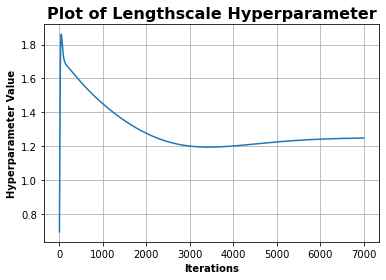

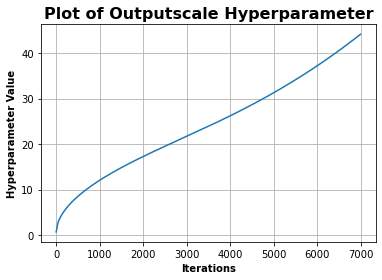

In [7]:
#Plot hyperparameters vs iteration
noise_title = "Noise Hyperparameter"
lengthscale_title = "Lengthscale Hyperparameter"
outputscale_title = "Outputscale Hyperparameter"
plot_hyperparams(iterations, noise_list,noise_title)
plot_hyperparams(iterations, lengthscale_list,lengthscale_title)
plot_hyperparams(iterations, outputscale_list,outputscale_title)

In [8]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval()

p=10
#Define Testing Space
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays
theta_space = torch.tensor(theta_mesh.T.reshape(-1, 2)) #25 x 2
# print(test_T)

In [9]:
GP_Output = calc_GP_outputs(model, likelihood, theta_space)

model_mean = GP_Output[0]
model_variance = GP_Output[1]
model_stdev = GP_Output[2]
model_sse = GP_Output[3]

#Finds the index where sse is the smallest and finds which Theta combination corresponds to that value
Theta_Opt_GP = theta_space[np.argmin(model_sse)].numpy() #1x2
print("The GP predicts that Theta1 =",Theta_Opt_GP[0],"and Theta2 =", Theta_Opt_GP[1])

#calculates best_error and expected improvement
best_error = np.argmax(model_sse)
ei = calc_ei_basic(best_error,model_mean,model_variance)
Theta_Best_Ei = theta_space[np.argmax(ei)].numpy()
print("The point that should be sampled next is Theta1 =",Theta_Best_Ei[0],"and Theta2 =", Theta_Best_Ei[1])
#Formats ei points into a suitable graphing form    
ei_map = ei.reshape(len(Theta1),-1) # 5x5
#Formats sse data points into a suitable graphing form    
sse_map = model_sse.reshape(len(Theta1),-1) #5 x 5
#Formats stdev data points into suitable graphing form
stdev_map = model_stdev.reshape(len(Theta1),-1) #5 x 5
# print(stdev_map)

The GP predicts that Theta1 = 0.22222222222222232 and Theta2 = -0.6666666666666667
The point that should be sampled next is Theta1 = -1.1111111111111112 and Theta2 = 2.0


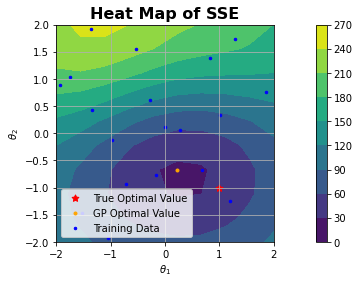

In [10]:
title = "SSE"
Theta_True = np.array([1,-1])
y_plotter_basic(theta_mesh, sse_map, Theta_True, Theta_Opt_GP, train_T,title,plot_train=True)

## Analysis of SSE
 - The GP predicts the optimal value excatly
 - The sum of squared error is closest to zero in the region closest to the actual optimal value of vector $\bar{\theta}$. This signifies that the GP is accurately predicting $\bar{\theta}$
 - The sum of squared error is greatest in the region as $\theta_1$ and $\theta_2$ deviate from their optimal values. This is further evidence that the GP is accurately predicting $\bar{\theta}$

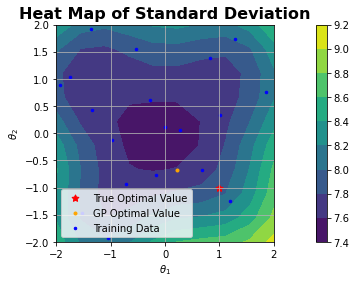

In [11]:
stdev_plotter_basic(theta_mesh, stdev_map,Theta_True, Theta_Opt_GP,train_T,plot_train=True)

## Analysis of Standard Deviation
 - The GP predicts the standard deviation is smallest when $\bar{\theta} = [0,0]$
 - The standard  deviation increases as $\bar{\theta}$ deviates further from zero
 - My guess is that this graph is cenetered at zero because the sse is independent of $\bar{\theta}$ at $\bar{\theta}=0$

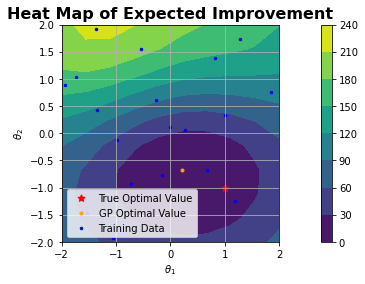

In [12]:
ei_plotter_basic(theta_mesh, ei_map, Theta_True, Theta_Opt_GP,train_T,plot_train=True)

## Analysis of Expected Improvement
 - The GP predicts the expected improvement is largest away from the optimal value. This is reasonable because the output of the GP is the SSE, which is largest away from the optimal point
 - The expected improvement is smallest in the area closest to $\bar{\theta}_{true}$ which makes sense because the error should be largest far away from the optimal point.